<a href="https://colab.research.google.com/github/ParthKhiriya/Sentiment_Analysis_PRML_Project/blob/3-model-branch/Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Importing the Dependencies**

In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')  # required for lemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - {'not', 'no', "don't", "didn't", "won't", "isn't", "aren't"}
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score
import joblib
from google.colab import files

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Step 2: Loading the Dataset**

In [3]:
# Installing the kaggle library
! pip install kaggle

In [4]:
# configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Fetching the API to download the dataset
! kaggle datasets download -d abhi8923shriv/sentiment-analysis-dataset

Dataset URL: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset
License(s): CC0-1.0
sentiment-analysis-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
from zipfile import ZipFile
dataset = '/content/sentiment-analysis-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [7]:
# Loading the main dataset and also the train and test set
df_train = pd.read_csv('train.csv', encoding='latin-1', header= None)
df_train = df_train.drop(labels=0)
df_train.columns = ["textID","text","selected_text","sentiment","Time of Tweet","Age of User","Country","Population -2020","Land Area (Km²)","Density (P/Km²)"]

# This gives the information about our data,  like what are the datatypes of content present in all the columns and also the null count
df_train = df_train.drop(["textID","selected_text","Time of Tweet","Age of User","Country","Population -2020","Land Area (Km²)","Density (P/Km²)"], axis=1)
df_train = df_train.dropna()
print(df_train)

                                                    text sentiment
1                    I`d have responded, if I were going   neutral
2          Sooo SAD I will miss you here in San Diego!!!  negative
3                              my boss is bullying me...  negative
4                         what interview! leave me alone  negative
5       Sons of ****, why couldn`t they put them on t...  negative
...                                                  ...       ...
27477   wish we could come see u on Denver  husband l...  negative
27478   I`ve wondered about rake to.  The client has ...  negative
27479   Yay good for both of you. Enjoy the break - y...  positive
27480                         But it was worth it  ****.  positive
27481     All this flirting going on - The ATG smiles...   neutral

[27480 rows x 2 columns]


In [8]:
# Loading the main dataset and also the train and test set
df_test = pd.read_csv('test.csv', encoding='latin-1', header= None)
df_test = df_test.drop(labels=0)
df_test.columns = ["textID","text","sentiment","Time of Tweet","Age of User","Country","Population -2020","Land Area (Km²)","Density (P/Km²)"]

# This gives the information about our data,  like what are the datatypes of content present in all the columns and also the null count
df_test = df_test.drop(["textID","Time of Tweet","Age of User","Country","Population -2020","Land Area (Km²)","Density (P/Km²)"], axis=1)
df_test = df_test.dropna()
print(df_test)

                                                   text sentiment
1     Last session of the day  http://twitpic.com/67ezh   neutral
2      Shanghai is also really exciting (precisely -...  positive
3     Recession hit Veronique Branquinho, she has to...  negative
4                                           happy bday!  positive
5                http://twitpic.com/4w75p - I like it!!  positive
...                                                 ...       ...
3530  its at 3 am, im very tired but i can`t sleep  ...  negative
3531  All alone in this old house again.  Thanks for...  positive
3532   I know what you mean. My little dog is sinkin...  negative
3533  _sutra what is your next youtube video gonna b...  positive
3534   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[3534 rows x 2 columns]


In [9]:
df = pd.concat([df_train, df_test], ignore_index=True)

# Shuffle the dataset (good practice before splitting again)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Showing basic info
print(df.shape)
print(df.head())

(31014, 2)
                                                text sentiment
0           I was afraid you were going to say that.  negative
1   part 2: social networking??.. there is even r...   neutral
2  i miss the one who would do anything to spend ...  negative
3    tee we beefin....what was u supposed to do b...   neutral
4              Happy Hug Your Mom Day!! love you mom  positive


In [10]:
# Converting the classes from negative, neutral, positive to 0,1,2 respectively
sentiment_ordering = ['negative', 'neutral', 'positive']

df["sentiment"] = df["sentiment"].apply(lambda x: sentiment_ordering.index(x))
print(df)

                                                    text  sentiment
0               I was afraid you were going to say that.          0
1       part 2: social networking??.. there is even r...          1
2      i miss the one who would do anything to spend ...          0
3        tee we beefin....what was u supposed to do b...          1
4                  Happy Hug Your Mom Day!! love you mom          2
...                                                  ...        ...
31009                 thanks to  and i`m now on twitter!          2
31010              My best friend is in vegas without me          1
31011  http://twitpic.com/4jken - fire and urban at r...          1
31012          A+ for effort though  http://bit.ly/Mco5v          2
31013  claire  love the show, got into the office @ 5...          2

[31014 rows x 2 columns]


# **Step 3: Data Pre-processing**

In [11]:
print(df['sentiment'].unique())
print(df['sentiment'].value_counts())
# Showing how many rows are there for each sentiment

[0 1 2]
sentiment
1    12547
2     9685
0     8782
Name: count, dtype: int64


In [12]:
lemmatizer = WordNetLemmatizer()

# This function performs basic tasks for cleaning the data such as lowercasing, URL handling etc.
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.lower()

    # Manual negation pairing
    negation_patterns = [("not", "good"), ("not", "happy"), ("not", "bad"),
                         ("not", "great"), ("not", "working"), ("no", "idea")]

    for neg, word in negation_patterns:
        text = text.replace(f"{neg} {word}", f"{neg}_{word}")

    text = re.sub(r"[^\w\s']", '', text)  # Keep contractions
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


# Save the cleaned text in our dataframe
df['cleaned_text'] = df['text'].apply(clean_text)

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Add polarity & subjectivity
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Add VADER features
df[['neg', 'neu', 'pos', 'compound']] = df['text'].apply(lambda x: pd.Series(vader.polarity_scores(x)))


print(df)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                    text  sentiment  \
0               I was afraid you were going to say that.          0   
1       part 2: social networking??.. there is even r...          1   
2      i miss the one who would do anything to spend ...          0   
3        tee we beefin....what was u supposed to do b...          1   
4                  Happy Hug Your Mom Day!! love you mom          2   
...                                                  ...        ...   
31009                 thanks to  and i`m now on twitter!          2   
31010              My best friend is in vegas without me          1   
31011  http://twitpic.com/4jken - fire and urban at r...          1   
31012          A+ for effort though  http://bit.ly/Mco5v          2   
31013  claire  love the show, got into the office @ 5...          2   

                                            cleaned_text  polarity  \
0                                       afraid going say -0.600000   
1      

# **Step 4: EDA**

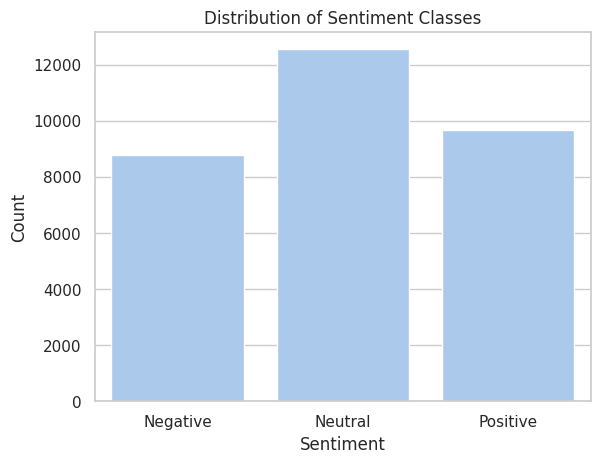

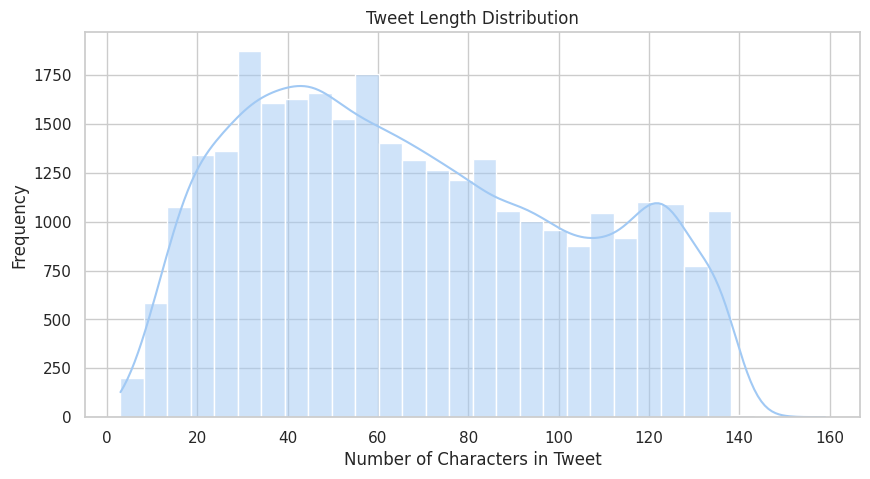

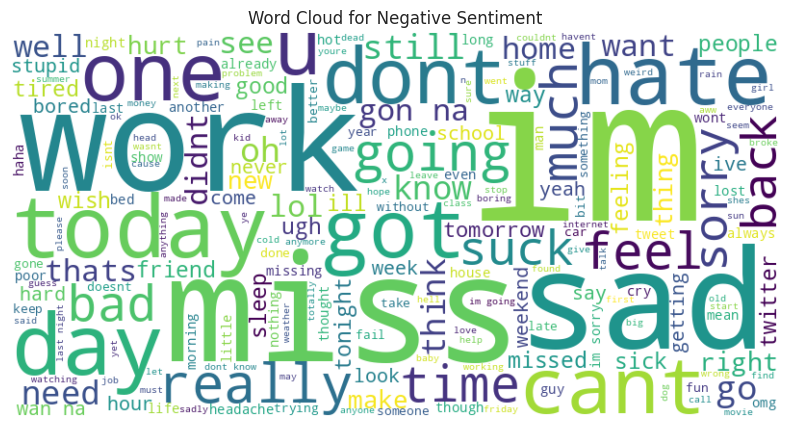

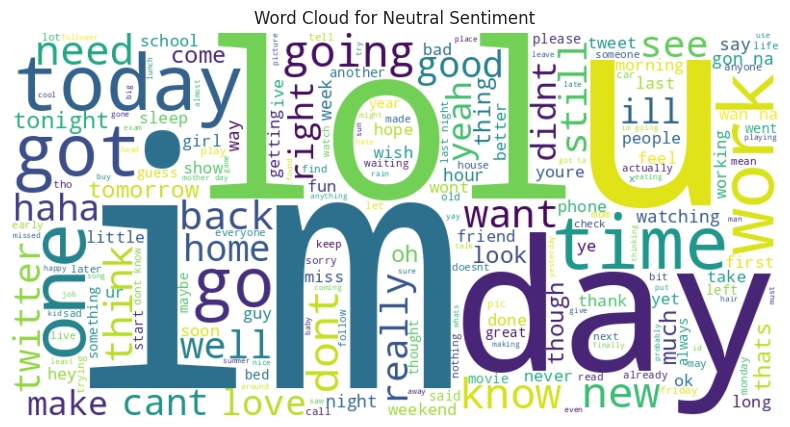

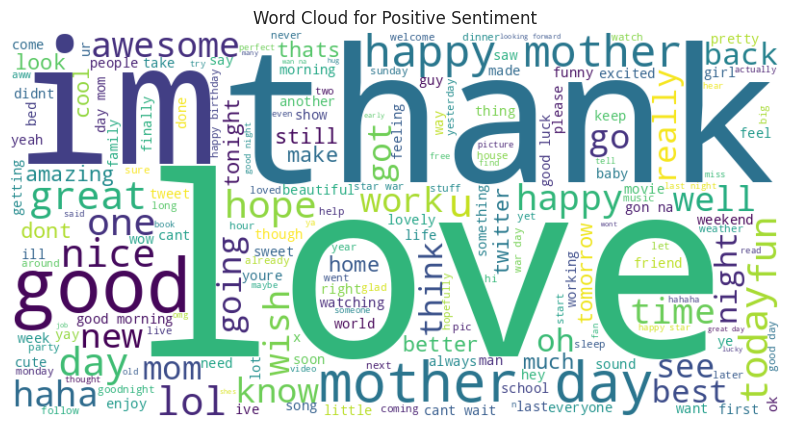

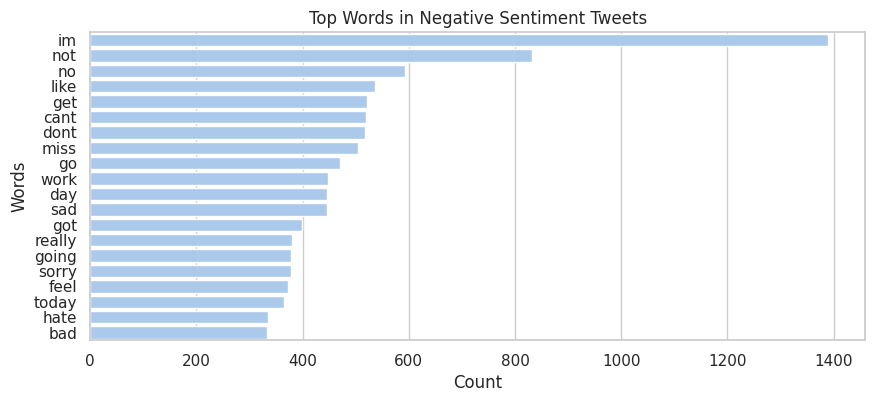

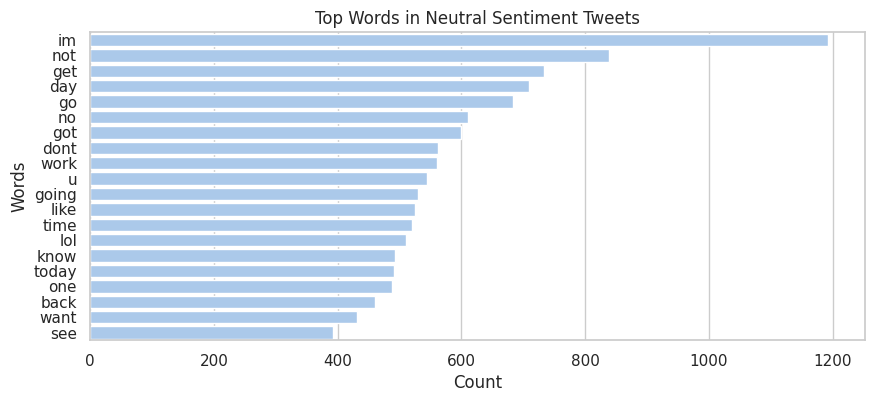

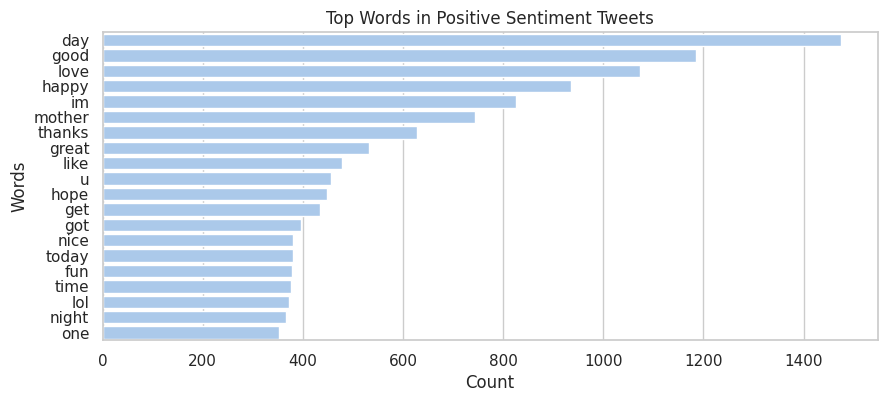

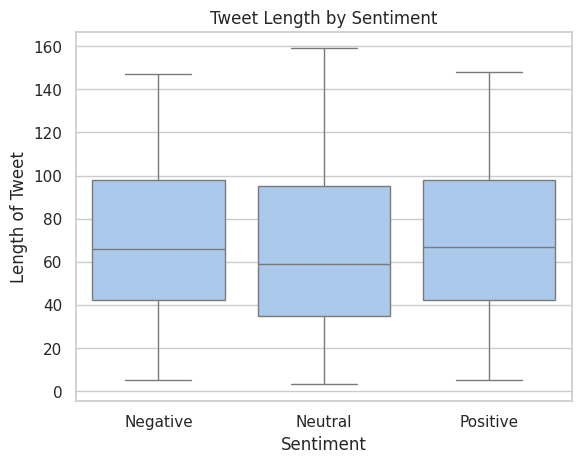

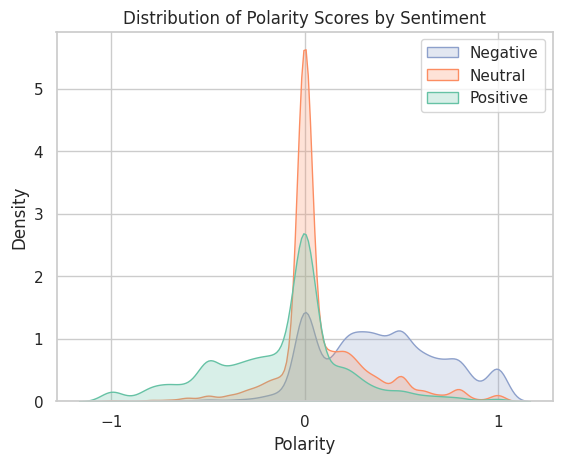

In [13]:
# Create a copy for EDA
df_eda = df.copy()

# 1. Sentiment Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", palette="pastel")

sns.countplot(data=df_eda, x='sentiment')
plt.title('Distribution of Sentiment Classes')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# 2. Tweet Length Distributions
df_eda['tweet_length'] = df_eda['text'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df_eda['tweet_length'], bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters in Tweet")
plt.ylabel("Frequency")
plt.show()

# 3. Word clouds for each sentiment
from wordcloud import WordCloud
import builtins

for i, label in builtins.zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    text = " ".join(df_eda[df_eda['sentiment'] == i]['cleaned_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label} Sentiment')
    plt.show()

# 4. Most frequent words
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)

for i, label in builtins.zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    top_words = get_top_words(df_eda[df_eda['sentiment'] == i]['cleaned_text'])
    words, counts = builtins.zip(*top_words)

    plt.figure(figsize=(10,4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top Words in {label} Sentiment Tweets')
    plt.xlabel("Count")
    plt.ylabel("Words")
    plt.show()

# 5. Tweet length vs sentiment
sns.boxplot(data=df_eda, x='sentiment', y='tweet_length')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.title("Tweet Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Length of Tweet")
plt.show()

# 6. Sentiment Polarity
df_eda['polarity'] = df_eda['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.kdeplot(data=df_eda, x='polarity', hue='sentiment', fill=True, common_norm=False, palette="Set2")
plt.xticks([-1, 0, 1])
plt.title('Distribution of Polarity Scores by Sentiment')
plt.xlabel("Polarity")
plt.ylabel("Density")
plt.legend(labels=['Negative', 'Neutral', 'Positive'])
plt.show()


# **Step 5: Vectorization**

In [14]:
# The y_train is the sentiment column consisting of values 0,1,2.
y = df['sentiment']

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Applying vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])

extra_features = df[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']].values
X_combined = hstack([X_tfidf, extra_features])  # Final input matrix

# Now split combined features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training Data:\n {X_train}")
print(f"Testing Data:\n {X_test}")

Training Data:
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 286838 stored elements and shape (24811, 10006)>
  Coords	Values
  (0, 210)	0.3759036391739198
  (0, 284)	0.33009213214546507
  (0, 776)	0.32340906212384274
  (0, 1646)	0.2695188053737899
  (0, 3153)	0.1704438287122285
  (0, 3164)	0.3759036391739198
  (0, 3692)	0.24426450826507456
  (0, 3740)	0.25995683216363896
  (0, 4836)	0.324978103508433
  (0, 5633)	0.1969159662796323
  (0, 7747)	0.24556209532776765
  (0, 8291)	0.26498504290463376
  (0, 10000)	-0.13333333333333333
  (0, 10001)	0.7833333333333333
  (0, 10002)	0.26
  (0, 10003)	0.595
  (0, 10004)	0.145
  (0, 10005)	-0.4767
  (1, 3153)	0.3191756179297277
  (1, 3187)	0.703922677763465
  (1, 7504)	0.40628759373788265
  (1, 9664)	0.48739119793464764
  (1, 10003)	1.0
  (2, 378)	0.7027432908933376
  (2, 3049)	0.3929403053947577
  :	:
  (24809, 6991)	0.5016509453869711
  (24809, 10000)	0.3
  (24809, 10001)	0.9
  (24809, 10002)	0.583
  (24809, 10003)	0.417
  (24809

# **Step 6: Applying Models**

**1. Logistic Regression**

In [15]:
log_reg = LogisticRegression(max_iter=3000, C=1.0)
log_reg.fit(X_train, y_train)

y_pred_train_logistic = log_reg.predict(X_train)
accuracy_train_logistic = accuracy_score(y_train, y_pred_train_logistic)
print(f"Training accuracy : {accuracy_train_logistic}")

y_pred_test_logistic = log_reg.predict(X_test)
accuracy_test_logistic = accuracy_score(y_test, y_pred_test_logistic)
print(f"Testing accuracy : {accuracy_test_logistic}")

# Classification report
print("Classification Report for Decision Tree on Test Set:")
print(classification_report(y_test, y_pred_test_logistic))

Training accuracy : 0.8034339607432187
Testing accuracy : 0.7228760277285184
Classification Report for Decision Tree on Test Set:
              precision    recall  f1-score   support

           0       0.76      0.64      0.70      1756
           1       0.66      0.75      0.70      2510
           2       0.79      0.76      0.78      1937

    accuracy                           0.72      6203
   macro avg       0.74      0.72      0.72      6203
weighted avg       0.73      0.72      0.72      6203



**2. Linear Regression**

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_train_linear = lin_reg.predict(X_train)
r2_train_linear = r2_score(y_train, y_pred_train_linear)
print(f"Training accuracy : {r2_train_linear}")

y_pred_test_linear = lin_reg.predict(X_test)
r2_test_linear = r2_score(y_test, y_pred_test_linear)
print(f"Testing accuracy : {r2_test_linear}")

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate and print regression metrics
mse = mean_squared_error(y_test, y_pred_test_linear)
rmse = mean_squared_error(y_test, y_pred_test_linear)  # RMSE
mae = mean_absolute_error(y_test, y_pred_test_linear)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Training accuracy : 0.7665610079248736
Testing accuracy : 0.2270699771124649
Mean Squared Error (MSE): 0.4595112627137402
Root Mean Squared Error (RMSE): 0.4595112627137402
Mean Absolute Error (MAE): 0.5128258033554054


**3. Support Vector Machines**

In [17]:
svm_model = SVC(C=1.0, kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Classification report
print("Classification Report for Decision Tree on Test Set:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7354505884249557
Classification Report for Decision Tree on Test Set:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1756
           1       0.68      0.76      0.72      2510
           2       0.80      0.77      0.79      1937

    accuracy                           0.74      6203
   macro avg       0.75      0.73      0.74      6203
weighted avg       0.74      0.74      0.74      6203



**4. Naive Bayes**

In [18]:
nb_model = MultinomialNB()
nb_model.fit(np.abs(X_train), y_train)

y_pred_nb = nb_model.predict(np.abs(X_test))
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# Classification report
print("Classification Report for Decision Tree on Test Set:")
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Accuracy: 0.6935353861034983
Classification Report for Decision Tree on Test Set:
              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1756
           1       0.62      0.77      0.69      2510
           2       0.77      0.71      0.74      1937

    accuracy                           0.69      6203
   macro avg       0.72      0.68      0.69      6203
weighted avg       0.71      0.69      0.69      6203



**5. XG Boost**

In [19]:
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Classification report
print("Classification Report for Decision Tree on Test Set:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7251330001612123
Classification Report for Decision Tree on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1756
           1       0.67      0.74      0.71      2510
           2       0.79      0.77      0.78      1937

    accuracy                           0.73      6203
   macro avg       0.73      0.72      0.73      6203
weighted avg       0.73      0.73      0.73      6203



**6. Decision Tree**

In [20]:
# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth = 12, random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Predictions
y_pred_train_dt = dt_clf.predict(X_train)
y_pred_test_dt = dt_clf.predict(X_test)

# Evaluate the model
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)

print(f"Decision Tree Training Accuracy: {accuracy_train_dt}")
print(f"Decision Tree Testing Accuracy: {accuracy_test_dt}")

# Classification report
print("Classification Report for Decision Tree on Test Set:")
print(classification_report(y_test, y_pred_test_dt))

Decision Tree Training Accuracy: 0.7579702551287735
Decision Tree Testing Accuracy: 0.6962759954860551
Classification Report for Decision Tree on Test Set:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1756
           1       0.66      0.70      0.68      2510
           2       0.74      0.75      0.75      1937

    accuracy                           0.70      6203
   macro avg       0.70      0.69      0.70      6203
weighted avg       0.70      0.70      0.70      6203



**7. Random Forest**

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Classification report
print("Classification Report for Decision Tree on Test Set:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7233596646783814
Classification Report for Decision Tree on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.67      0.70      1756
           1       0.68      0.71      0.70      2510
           2       0.78      0.78      0.78      1937

    accuracy                           0.72      6203
   macro avg       0.73      0.72      0.72      6203
weighted avg       0.72      0.72      0.72      6203



# **Step 7: Visualization**

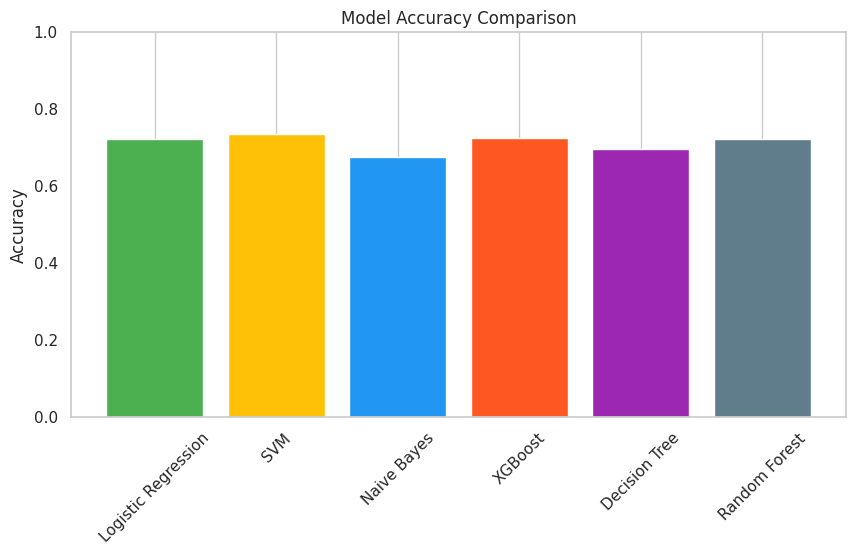

In [22]:
accuracies = {
    "Logistic Regression": accuracy_score(y_test, log_reg.predict(X_test)),
    "SVM": accuracy_score(y_test, svm_model.predict(X_test)),
    "Naive Bayes": accuracy_score(y_test, nb_model.predict(X_test)),
    "XGBoost": accuracy_score(y_test, xgb_model.predict(X_test)),
    "Decision Tree": accuracy_score(y_test, dt_clf.predict(X_test)),
    "Random Forest": accuracy_score(y_test, rf_model.predict(X_test))
}

plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['#4CAF50', '#FFC107', '#2196F3', '#FF5722', '#9C27B0', '#607D8B'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


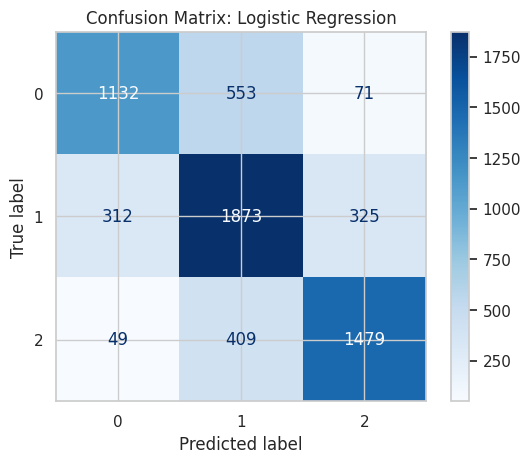

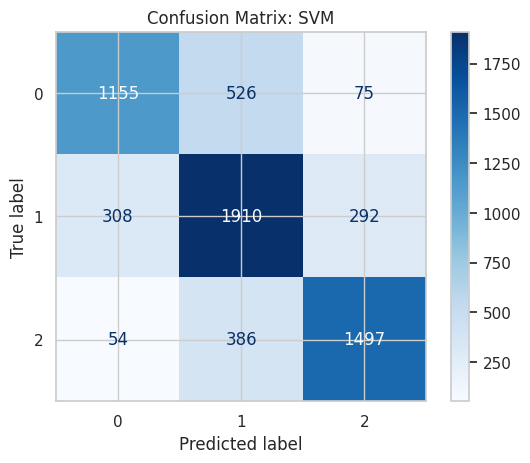

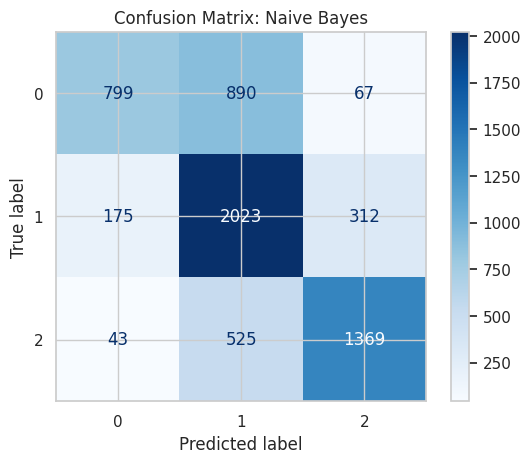

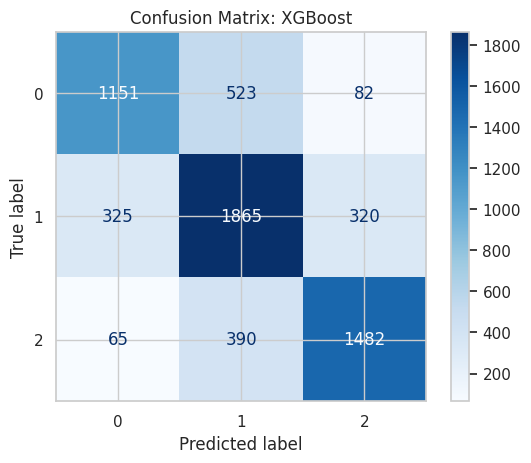

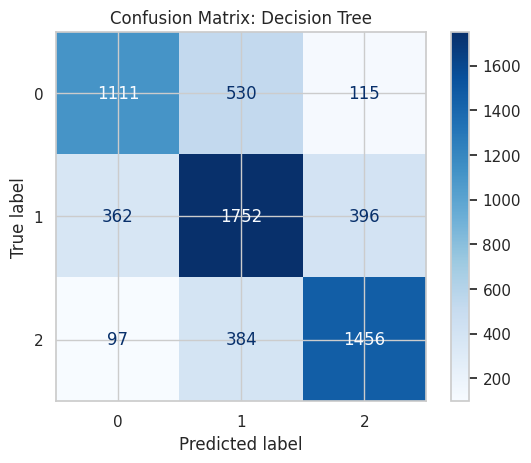

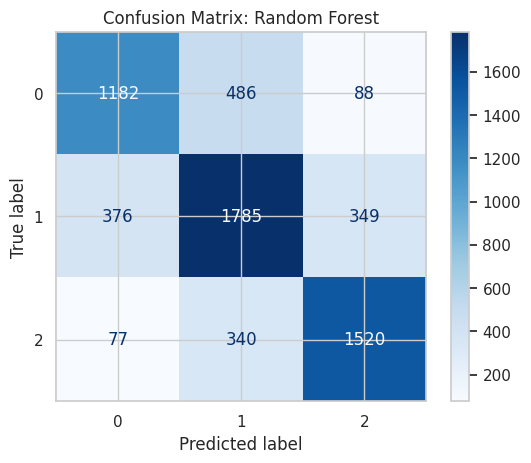

In [23]:
models = {
    "Logistic Regression": log_reg,
    "SVM": svm_model,
    "Naive Bayes": nb_model,
    "XGBoost": xgb_model,
    "Decision Tree": dt_clf,
    "Random Forest": rf_model
}

for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()


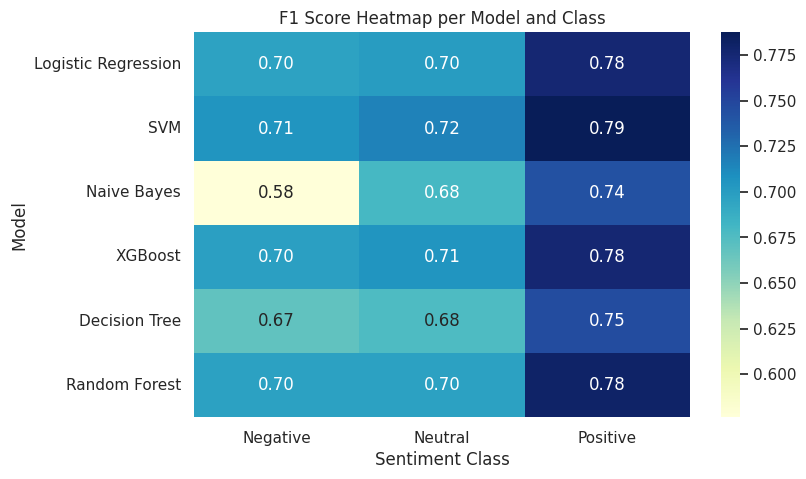

In [24]:
f1_scores = {}

for name, model in models.items():
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    f1_scores[name] = {
        'Negative': report['0']['f1-score'],
        'Neutral': report['1']['f1-score'],
        'Positive': report['2']['f1-score']
    }

df_f1 = pd.DataFrame(f1_scores).T

plt.figure(figsize=(8,5))
sns.heatmap(df_f1, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("F1 Score Heatmap per Model and Class")
plt.ylabel("Model")
plt.xlabel("Sentiment Class")
plt.show()


# **Step 8: Exporting Results**

In [31]:
# Save existing models
joblib.dump(log_reg, 'log_reg.pkl')
joblib.dump(lin_reg, 'lin_reg.pkl')
joblib.dump(nb_model, 'nb_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(dt_clf, 'dt_model.pkl')



# Save the shared vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [32]:
# Existing models
files.download('log_reg.pkl')
files.download('lin_reg.pkl')
files.download('nb_model.pkl')
files.download('xgb_model.pkl')
files.download('svm_model.pkl')
files.download('dt_model.pkl')

# Shared vectorizer
files.download('vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# Existing models
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

y_pred_lin = lin_reg.predict(X_test)
acc_lin = r2_score(y_test, y_pred_lin)  # Regression model

y_pred_nb = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

y_pred_dt = dt_clf.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)


In [34]:
accuracies = {
    'Logistic Regression': acc_log,
    'Linear Regression (R²)': acc_lin,
    'Naive Bayes': acc_nb,
    'XGBoost': acc_xgb,
    'SVM': acc_svm,
    'Decision Tree': acc_dt
}

# Save as pkl
joblib.dump(accuracies, 'accuracies.pkl')


# For downloading in Jupyter Notebook
files.download('accuracies.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>